In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from Pre_processing import *
from dython.nominal import associations
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.ensemble import AdaBoostClassifier
pd.set_option('mode.chained_assignment', None)

In [2]:

dbfile = open('milestone2_Pickle', 'rb')     
db = pickle.load(dbfile)
dbfile.close()
print(db.keys())

dict_keys(['model1', 'mode12', 'mode13', 'Top_features', 'statistics'])


In [3]:
model1 = db['model1']
model2 = db['mode12']
model3 = db['mode13']
top_feature = db['Top_features']
statistics = db['statistics']

In [4]:
#Read data from file #
def getData(path):
    data = pd.read_csv(path)
    temp = []
    for i in data['national_team']:
        if type(i) != str:
            value = '0'
        else:
            value = '1'
        temp.append(value)
    data['national_team'] = temp
   
    return data
data = getData('player-classification.csv')
## get mean or mode for every column in data
mean_mode = get_mode_means(data)


In [5]:
def preprocessing(data):
    data = data.loc[:, data.isnull().sum() < 0.25*data.shape[0]]
    
    #split column 'position'
    temp = []
    for i in data['positions']:
        l = i.split(',')
        temp.append(l[0])
    data['positions'] = temp
    #split column 'work_rate'
    temp.clear()
    for i in data['work_rate']:
        l = i.split('/')
        temp.append(l[0])
    data['work_rate'] = temp
    
    #Replace null value with mean at wage and value columns
    data['PlayerLevel'].fillna(value=mean_mode['PlayerLevel'], inplace=True)
    data['wage'].fillna(value=mean_mode['wage'], inplace=True)
    data.dropna(how='any',inplace=True)

    #fix certain columns in data 
    Columns=['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']
    for i in Columns:
        position(i,data)

    #Date encodig
    date_toInt(data,'contract_end_year')
    date_toInt(data,'birth_date')
    date_toInt(data,'club_join_date')
   
    return data

data = preprocessing(data)


In [6]:

# df = data[['overall_rating', 'potential', 'wage', 'skill_moves(1-5)',
#        'release_clause_euro', 'club_rating', 'short_passing', 'dribbling',
#        'long_passing', 'ball_control', 'reactions', 'shot_power', 'vision',
#        'composure', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
#        'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
#        'RDM', 'RWB','club_team','PlayerLevel']]
            
# ###correlation
# correlation = associations(
#         data, filename='correlation.png', figsize=(8, 10),)




In [7]:
#get features with correlation grater than 0.55
# top_feature =correlation['corr'].index[abs(correlation['corr']['PlayerLevel'])>0.55]
# top_feature = top_feature.delete(-1)


In [8]:
#Encoding categorical data 
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
data, encoders = Feature_Encoder(data,categorical_columns)
def preprocessing2(dt):
    #Drop columns which do not affect on our model
    dt=dt.drop(['id','name','full_name','birth_date'], axis = 1)
    return dt
data= preprocessing2(data)


In [9]:
#Assign X(features) and Y(target) data
features = []
features.append(top_feature)
features.append(['reactions','composure','CM','RCM','ST','RS','CF','RF','CAM','RAM'])
X = data[features[0]]
#X.insert(0,'national_team',data['national_team'])
#drop high correlated feauters
X=X.drop(features[1], axis = 1)
Y=data["PlayerLevel"]

In [10]:
##split data to test and train 80% : 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,shuffle=True,random_state=10)
X_train, X_test, Scaler = Preprocessing_Scaling(X_train, X_test)


In [11]:
# statistics = {}
# ## DecisionTree_Classifier “gini”, “entropy”, “log_loss”
# model1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=13,max_leaf_nodes = 50),
#                          algorithm="SAMME",
#                          n_estimators=100,random_state=15)
# time1_train = time.time()
# model1.fit(X_train,y_train)
# time1_train = time.time() - time1_train
print('DecisionTreeClassifierModel Train Score is : ' , model1.score(X_train, y_train))
time1_test = time.time()
model1_accuracy = model1.score(X_test, y_test)
time1_test = time.time() - time1_test
print('DecisionTreeClassifierModel Test Score is : ' , model1_accuracy )
print('----------------------------------------------------')
# statistics['model1'] = [model1_accuracy,time1_train,time1_test]

DecisionTreeClassifierModel Train Score is :  1.0
DecisionTreeClassifierModel Test Score is :  0.9586298932384342
----------------------------------------------------


In [12]:
##Svm_Classifier
# model2 = svm.SVC(C=1200,kernel='rbf',gamma = 0.02)

# time2_train = time.time()
# model2.fit(X_train,y_train)
# time2_train = time.time() - time2_train

time2_test = time.time()
model2_accuracy = model2.score(X_test, y_test)
time2_test = time.time() - time2_test
print('SvmClassifierModel Train Score is : ' , model2.score(X_train, y_train))
print('SvmClassifierModel Test Score is : ' , model2_accuracy )
# statistics['model2'] = [model2_accuracy,time2_train,time2_test]

SvmClassifierModel Train Score is :  0.9562798976526866
SvmClassifierModel Test Score is :  0.9261565836298933


In [13]:
#LogisticRegression_Classifier
poly = PolynomialFeatures( degree = 2 , include_bias = False)
poly.fit(X_train)
x_poly_train = poly.transform(X_train)
# model3 = LogisticRegression(C = 1000 , max_iter = 10000 )

# time3_train = time.time()
# model3.fit(x_poly_train,y_train)
# time3_train = time.time() - time3_train
x_poly_test = poly.transform(X_test)
time3_test = time.time()
model3_accuracy = model3.score(x_poly_test, y_test)
time3_test = time.time() - time3_test
print('LogisticRegressionClassifierModel Train Score is : ' , model3.score(x_poly_train, y_train))
print('LogisticRegressionClassifierModel Test Score is : ' , model3_accuracy )
# statistics['model3'] = [model3_accuracy,time3_train,time3_test]

LogisticRegressionClassifierModel Train Score is :  0.9585048392479697
LogisticRegressionClassifierModel Test Score is :  0.9261565836298933


In [14]:
def fillnaa(df):
    
    #handel cat vars
    #print(df.isnull().sum())
    for i in df:
        df[i].fillna(value=mean_mode[i], inplace=True)
    #print(df.isnull().sum())
    return df
def testfile(path,features,model):
    #Split data
    df = getData(path)
    df = fillnaa(df)
    df = preprocessing(df)
    df = encoder_transform(df,encoders.keys(),encoders )
    df = preprocessing2(df)
    xx = df[features[0]]
    xx = xx.drop(features[1], axis = 1)
    yy = df["PlayerLevel"]
    xx = Scaler.transform(xx)
    y_pred1 = model.predict(xx)
    print('Predicted Value for DecisionTreeClassifierModel is : ' , y_pred1[:20])
    print('Predicted class for DecisionTreeClassifierModel is : ' , encoders["PlayerLevel"].inverse_transform(y_pred1[:20]))
    print('DecisionTreeClassifierModel Test Score is : ' , model.score(xx, yy)*100,'%')

testfile('player-test-samples.csv',features,model1)

Predicted Value for DecisionTreeClassifierModel is :  [0 2 2]
Predicted class for DecisionTreeClassifierModel is :  ['A' 'C' 'C']
DecisionTreeClassifierModel Test Score is :  100.0 %


In [15]:
statistics

{'model1': [0.9586298932384342, 4.857203483581543, 0.05424904823303223],
 'model2': [0.9261565836298933, 2.601562261581421, 0.6512620449066162],
 'model3': [0.9261565836298933, 77.90359854698181, 0.0009961128234863281]}

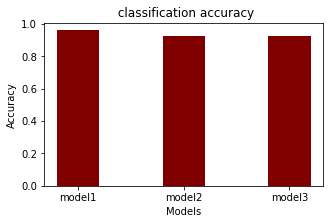

In [16]:

import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (5, 3))
x_  = list(statistics.keys())
y_  = []
for i in statistics:
    y_.append(statistics[i][0])
# creating the bar plot
plt.bar(x_, y_, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title(" classification accuracy")
plt.show()

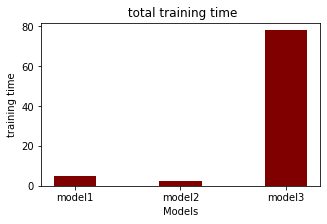

In [17]:
fig = plt.figure(figsize = (5, 3))
x_  = list(statistics.keys())
y_  = []
for i in statistics:
    y_.append(statistics[i][1])
    
# creating the bar plot
plt.bar(x_, y_, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("training time")
plt.title(" total training time")
plt.show()

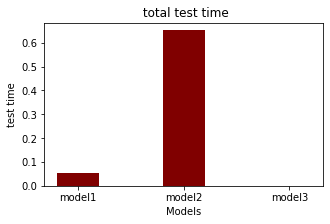

In [18]:
fig = plt.figure(figsize = (5, 3))
x_  = list(statistics.keys())
y_  = []
for i in statistics:
    y_.append(statistics[i][2])
plt.bar(x_, y_, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("test time")
plt.title(" total test time")
plt.show()

In [19]:

# db = {}
# db['model1'] = model1
# db['mode12'] = model2
# db['mode13'] = model3
# db['Top_features'] = top_feature
# db['statistics'] = statistics
# dbfile = open('milestone2_Pickle', 'ab')

# # source, destination
# pickle.dump(db, dbfile)                     
# dbfile.close()